In [1]:
import deepquantum as dq
import numpy as np
import torch
print('version',dq.__version__)

version 4.2.0


# 基于测量的量子计算（MBQC）模块

## 构建``Pattern``

### 通过转译``QubitCircuit``线路构建``Pattern``

构建``QubitCircuit``

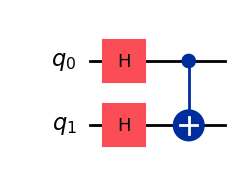

In [2]:
cir = dq.QubitCircuit(2)
cir.h(0)
cir.h(1)
cir.cnot(0, 1)
cir.draw()

转译为MBQC的``Pattern``类

In [3]:
# Transpile circuit to measurement pattern
pattern = cir.pattern()
pattern

Pattern(
  (init_state): GraphState(
    (subgraphs): ModuleList(
      (0): SubGraphState(nodes_state=[0], nodes=[0])
      (1): SubGraphState(nodes_state=[1], nodes=[1])
    )
  )
  (commands): Sequential(
    (0): Node(nodes=[2])
    (1): Entanglement(nodes=[0, 2])
    (2): Measurement(nodes=[0], plane=XY, angle=0.0, s_domain=set(), t_domain=set())
    (3): Correction(basis=x, nodes=[2], domain={0})
    (4): Node(nodes=[3])
    (5): Entanglement(nodes=[1, 3])
    (6): Measurement(nodes=[1], plane=XY, angle=0.0, s_domain=set(), t_domain=set())
    (7): Correction(basis=x, nodes=[3], domain={1})
    (8): Node(nodes=[4, 5])
    (9): Entanglement(nodes=[3, 4])
    (10): Entanglement(nodes=[2, 4])
    (11): Entanglement(nodes=[4, 5])
    (12): Measurement(nodes=[3], plane=XY, angle=0.0, s_domain=set(), t_domain=set())
    (13): Measurement(nodes=[4], plane=XY, angle=0.0, s_domain=set(), t_domain=set())
    (14): Correction(basis=x, nodes=[5], domain={4})
    (15): Correction(basis=z, nod

如果``QubitCircuit``初态是batch形式，转译后的``Pattern``初态依然是batch。

In [4]:
n_qubits = 2
batch_size = 5
init_state = torch.rand(batch_size, 2**n_qubits)
init_state = init_state / torch.norm(init_state, dim=-1, keepdim=True)  # normalize

cir = dq.QubitCircuit(n_qubits, init_state=init_state)
cir.h(0)
cir.h(1)
cir.cnot(0, 1)

pattern = cir.pattern()

print(pattern.init_state.full_state.shape)
pattern.init_state.full_state

torch.Size([5, 4, 1])


tensor([[[0.4079+0.j],
         [0.7564+0.j],
         [0.2442+0.j],
         [0.4493+0.j]],

        [[0.6365+0.j],
         [0.2205+0.j],
         [0.5942+0.j],
         [0.4396+0.j]],

        [[0.2628+0.j],
         [0.8253+0.j],
         [0.2220+0.j],
         [0.4477+0.j]],

        [[0.4059+0.j],
         [0.6786+0.j],
         [0.1642+0.j],
         [0.5897+0.j]],

        [[0.2543+0.j],
         [0.1615+0.j],
         [0.6826+0.j],
         [0.6659+0.j]]])

可视化构建的图态。其中，方形node表示输入，edge表示node间存在CZ纠缠，蓝色node表示待测，剩余的灰色node表示输出。

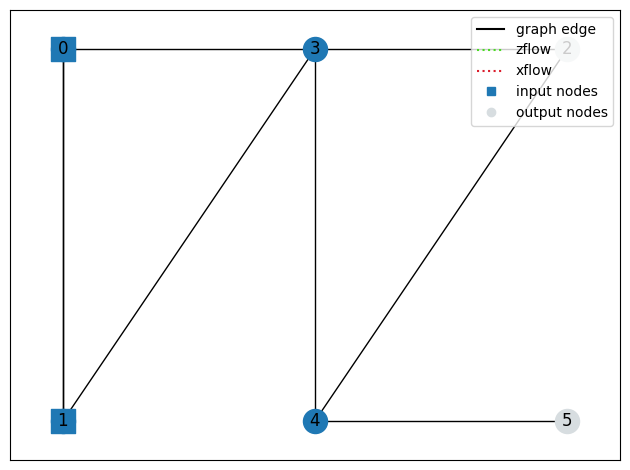

In [5]:
pattern.draw()

### 手动构建``Pattern``

除了通过``QubitCircuit``的转译，用户可以初始化``Pattern``后，通过手动添加``NEMC``commands，构建自定义的``Pattern``。

输入的节点可以用初始化参数中`nodes_state`表示，而初态用参数`state`控制，默认为全 $ \left |+\right \rangle$ 态。

tensor([[0.5000+0.j],
        [0.5000+0.j],
        [0.5000+0.j],
        [0.5000+0.j]])


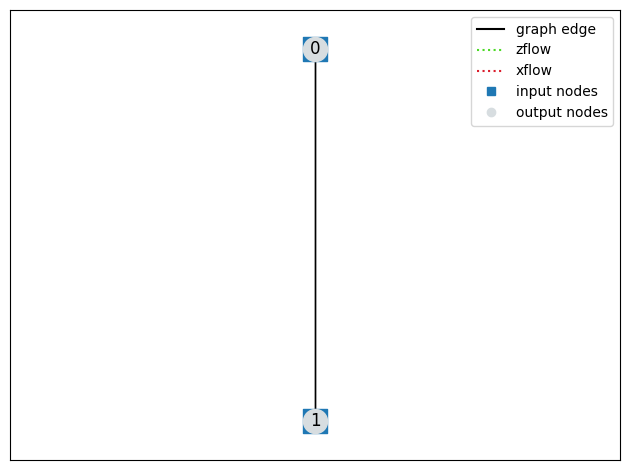

In [6]:
pattern = dq.Pattern(nodes_state=[0, 1])

print(pattern.init_state.full_state)

pattern.draw()

In [7]:
# 自定义初态
pattern = dq.Pattern(nodes_state=[0, 1], state=[1, 0, 0, 0])

print(pattern.init_state.full_state)

tensor([[1.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j]])


可以在`nodes_state`的基础上，额外加入`edges`和`nodes`作为输入的初始图态。

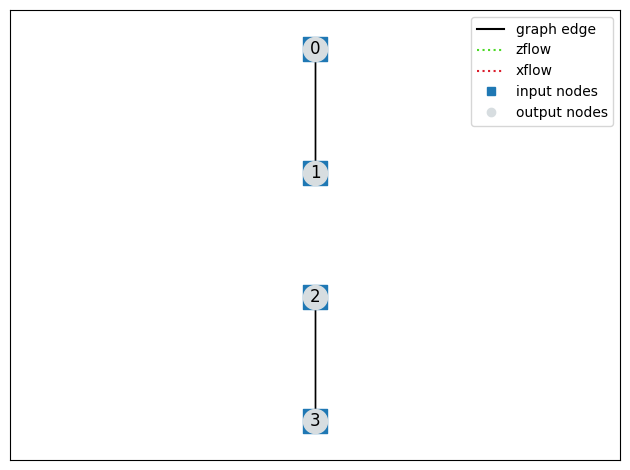

In [8]:
pattern = dq.Pattern(nodes_state=[0, 1], nodes=[2, 3], edges=[[2,3]])

pattern.draw()

根据NEMC Commands序列，生成特定的``Pattern``

| Command | 定义 | Pattern函数 |
|------|------|------|
| $N_i$ | Node (qubit) preparation command with node index $i$ | $n(i)$ |
| $E_{ij}$ | Entanglement command which apply $CZ$ gate to nodes $(i, j)$ | $e(i, j)$ | 
| $^t[M_i^{\lambda, \alpha}]^s$ | Measurement command which perform measurement of node $i$ ,with <br>measurement plane $\lambda = XY, YZ$ or $XZ$, <br>measurement angle $\alpha$ defined on the plane $\lambda$, <br>$s$ and $t$ feedforward domains that adaptively changes the measurement angles to $\alpha' = (-1)^{q_s}\alpha + \pi q_t$, <br>where $q_s, q_t$ are the sum of all measurement outcomes in the $s$ and $t$ domains. | $m(i, \alpha, \lambda, t, s)$ |
| $X_i^s$ | Correction X command applied to qubit $i$ with signal domain $s$ | $x(i, s)$ |
| $Z_i^s$ | Correction Z command applied to qubit $i$ with signal domain $s$ | $z(i, s)$ |

例如，生成 $ X_3^{s_0+s_1}\ ^{t_1} [M_2^{\pi}]^{s_0}E_{23}N_3[M_1^{\pi}]^{s_0} M_0^{\pi}E_{12}E_{02}N_2E_{01}N_1N_0$

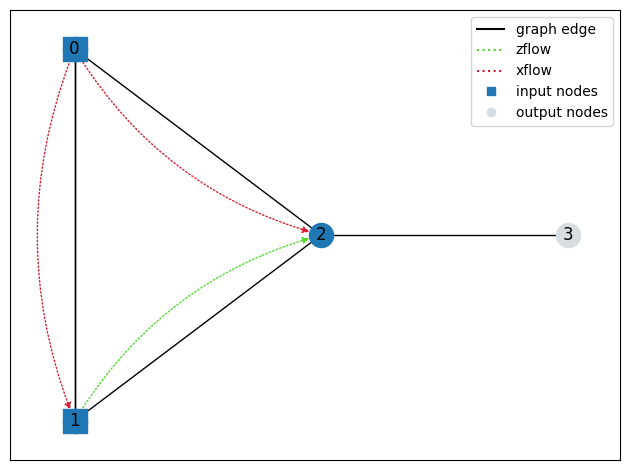

In [9]:
pattern = dq.Pattern(nodes_state=[0, 1])
pattern.n(2)
pattern.e(0, 2)
pattern.e(1, 2)
pattern.m(node=0, angle=np.pi)
pattern.m(node=1, angle=np.pi, s_domain=[0])
pattern.n(3)
pattern.e(2,3)
pattern.m(node=2, angle=np.pi, s_domain=[0], t_domain=[1])
pattern.x(node=3, domain=[0, 1])
pattern.draw()


## 优化Pattern

进行``standardize``操作，将``Pattern``从右向左按NEMC的指令类型进行排列，形成标准形式。

注意，相比wild pattern, standard form会占用更多内存。如果标准化后出现内存溢出的报错，可以尝试对wild pattern直接进行前向演化。

In [11]:
pattern.standardize()
pattern

Pattern(
  (init_state): GraphState(
    (subgraphs): ModuleList(
      (0): SubGraphState(nodes_state=[0, 1], nodes=[0, 1])
    )
  )
  (commands): Sequential(
    (0): Node(nodes=[2])
    (1): Node(nodes=[3])
    (2): Entanglement(nodes=[0, 2])
    (3): Entanglement(nodes=[1, 2])
    (4): Entanglement(nodes=[2, 3])
    (5): Measurement(nodes=[0], plane=XY, angle=3.1415927410125732, s_domain=set(), t_domain=set())
    (6): Measurement(nodes=[1], plane=XY, angle=3.1415927410125732, s_domain={0}, t_domain=set())
    (7): Measurement(nodes=[2], plane=XY, angle=3.1415927410125732, s_domain={0}, t_domain={1})
    (8): Correction(basis=x, nodes=[3], domain={0, 1})
  )
)

通过signal shifting 进一步优化，目的是消除测量角度对于``t_domain``的依赖(Z-dependency)，从而降低量子深度。

In [13]:
pattern.shift_signals()
pattern

Pattern(
  (init_state): GraphState(
    (subgraphs): ModuleList(
      (0): SubGraphState(nodes_state=[0, 1], nodes=[0, 1])
    )
  )
  (commands): Sequential(
    (0): Node(nodes=[2])
    (1): Node(nodes=[3])
    (2): Entanglement(nodes=[0, 2])
    (3): Entanglement(nodes=[1, 2])
    (4): Entanglement(nodes=[2, 3])
    (5): Measurement(nodes=[0], plane=XY, angle=3.1415927410125732, s_domain=set(), t_domain=set())
    (6): Measurement(nodes=[1], plane=XY, angle=3.1415927410125732, s_domain={0}, t_domain=set())
    (7): Measurement(nodes=[2], plane=XY, angle=3.1415927410125732, s_domain={0}, t_domain=set())
    (8): Correction(basis=x, nodes=[3], domain={0, 1})
  )
)

通过图态的可视化，可以观察到signal shifting后的测量不再依赖于绿色的Z修正。

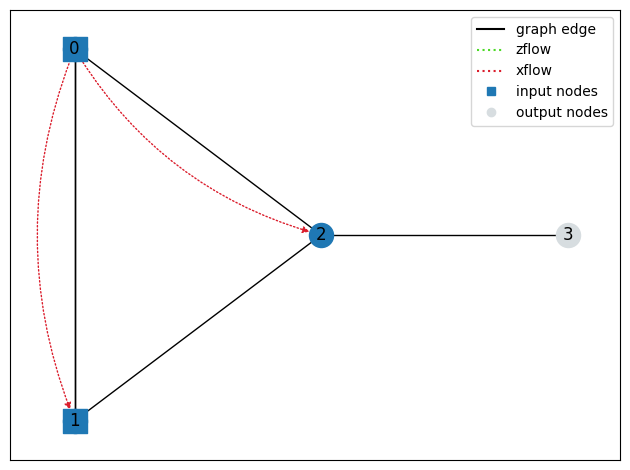

In [56]:
pattern.draw()

## 执行MBQC模拟

### 前向演化

和DeepQuantum其它模块一样，仅需一个前向函数即可执行对``Pattern``的模拟。

In [57]:
pattern()

GraphState(
  (subgraphs): ModuleList(
    (0): SubGraphState(nodes_state=[3], nodes=[3])
  )
)

返回的结果是末态输出的``GraphState``，使用属性``full_state``可以得到末态的态矢。

In [60]:
state = pattern().full_state
state

tensor([[-0.7071+6.1817e-08j],
        [-0.7071+6.1817e-08j]])

对应的测量结果由``GraphState``中``measure_dict``保存：

In [63]:
pattern.state.measure_dict

defaultdict(list, {0: [1], 1: [1], 2: [0]})

支持通过 ``data`` 输入``Pattern``中 ``encode=True`` 的command参数(即测量角度)，通过 ``state`` 指定初态，对``Pattern``进行演化：

In [65]:
pattern = dq.Pattern(nodes_state=[0, 1])
pattern.n(2)
pattern.e(0, 2)
pattern.e(1, 2)
pattern.m(node=0, encode=True)
pattern.m(node=1, encode=True, s_domain=[0])
pattern.x(node=2, domain=[0, 1])

angle = torch.randn(2)
pattern(data=angle).full_state

tensor([[0.1295-0.9896j],
        [0.0082-0.0624j]])

初态的类型需要是``GraphState``：

In [76]:
init_graph_state = dq.GraphState([0, 1], state=[1, 0, 0, 0])

pattern(data=angle, state=init_graph_state).full_state

tensor([[-0.7071+6.1817e-08j],
        [-0.7071+6.1817e-08j]])

### 支持batch输入

测量角度的batch输入:

In [78]:
angle = torch.randn(6, 2)
pattern(data=angle).full_state

tensor([[[ 0.0484-0.0662j],
         [-0.5882+0.8046j]],

        [[ 0.9159-0.3787j],
         [ 0.1227-0.0507j]],

        [[ 0.9108-0.4121j],
         [-0.0231+0.0105j]],

        [[-0.0800-0.1890j],
         [-0.3814-0.9013j]],

        [[ 0.2985-0.3118j],
         [ 0.6238-0.6515j]],

        [[-0.0528-0.0011j],
         [-0.9984-0.0209j]]])

初态的batch输入：

In [80]:
init_graph_state = dq.GraphState([0, 1], state=[[1, 0, 0, 0],
                                                [0, 1, 0, 0]])

pattern(state=init_graph_state).full_state

tensor([[[-0.7071+6.1817e-08j],
         [-0.7071+6.1817e-08j]],

        [[ 0.6422+2.9585e-01j],
         [-0.6422-2.9585e-01j]]])

也支持转译前``QubitCircuit``中参数化门的encode：

In [90]:
cir = dq.QubitCircuit(2)
cir.h(0)
cir.rz(0, encode=True)
cir.ry(1, encode=True)
cir.cnot(0, 1)

pattern = cir.pattern()

data = torch.randn(2)
print(pattern(data=data).full_state)

data = torch.randn(6, 2)
print(pattern(data=data).full_state)

tensor([[-0.4243+0.3464j],
        [ 0.3464-0.2828j],
        [ 0.4081-0.1828j],
        [-0.4999+0.2240j]])
tensor([[[-0.3396-0.2552j],
         [ 0.4519+0.3396j],
         [ 0.2653+0.4991j],
         [-0.1994-0.3751j]],

        [[-0.1818-0.6568j],
         [ 0.0503+0.1818j],
         [ 0.1861+0.0306j],
         [-0.6724-0.1106j]],

        [[ 0.7039+0.0478j],
         [ 0.0478+0.0033j],
         [ 0.0379-0.0294j],
         [ 0.5579-0.4318j]],

        [[ 0.3519-0.3198j],
         [ 0.3873-0.3519j],
         [ 0.4586-0.2521j],
         [ 0.4167-0.2291j]],

        [[ 0.6077-0.2458j],
         [-0.2458+0.0994j],
         [-0.2559+0.0691j],
         [ 0.6328-0.1710j]],

        [[-0.2194+0.6308j],
         [-0.0763+0.2194j],
         [-0.0486+0.2271j],
         [-0.1397+0.6531j]]])


### 支持自动微分

MBQC模块支持基于``PyTorch``的自动微分，用户可以利用这一特性设计和模拟含梯度优化的变分算法(VMBQC)。

In [107]:
data = torch.randn(2, requires_grad=True)
pattern(data=data).full_state

tensor([[-0.1142-0.3647j],
        [-0.2762-0.8819j]], grad_fn=<SqueezeBackward1>)